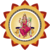

# 🕉️ **Devi : Temple Information Chatbot**

This project demonstrates how to build a powerful and fact-checked chatbot using the **Gemini API** and **Google Search Grounding**.

The chatbot, named **Devi**, is specifically designed to answer questions about the **Sri Lalithambigai Temple (UK)**. By using Google Search grounded only on the temple's official website, we ensure that all factual responses are up-to-date and directly sourced.

---

## 🔑 **Setup: Retrieve Your API Key**

To run the chatbot, you must secure your **Gemini API Key** and set it as an environment variable.

1.  **Get Key:** Visit Google AI Studio and generate your API Key.
2.  **Set Environment Variable in Colab:** Run the following two cells, pasting your API key into the `userdata.get()` function when prompted.

```python
import os
from google.colab import userdata

# IMPORTANT:
# Replace 'YOUR_API_KEY_NAME' with the actual name you gave your secret in Colab secrets.
# If you didn't save it as a secret, simply replace userdata.get('GOOGLE_API_KEY') with
# 'your_actual_api_key_string' (but using secrets is highly recommended).
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')
```

---

## 🛠️ **Key Technical Features**

### **1. Google Search Grounding (`tools`)**

The core feature of this chatbot is the use of the `tools` property in the API call, which activates the **Google Search** tool.

  * **Reliability:** Answers are generated based on real-time web search results.
  * **Specificity:** The user's query is programmatically augmented with the `site:srilalithambigaitemple.co.uk` operator to ensure the search is constrained to the temple's official domain, maximizing the relevance of the grounding data.
  * **Citations:** The code extracts and displays the **source URIs** and titles (citations) used by the model, allowing users to verify the information.

### **2. System Instruction (`systemInstruction`)**

A clear system instruction is used to define the model's persona and rules of engagement:

  * **Role:** Act as 'Devi', the knowledgeable bot for the Sri Lalithambigai Temple.
  * **Rule:** **Only** use information from the provided search results/website.

### **3. Exponential Backoff**

The `generateContentWithRetry` function includes an **exponential backoff mechanism** to handle transient network issues or rate-limiting (429 errors), making the application more robust.

---

**What is Exponential Backoff?**

**Exponential backoff** is a standard strategy for managing failures when making repeated requests to a networked service or API. It's an algorithm that determines how long a client should wait before retrying a failed request, with the crucial feature that the wait time gets **longer** with each subsequent failure.

**Why We Use It**

When an application fails to connect to a service (like the Gemini API) it's often due to a **transient error**. These temporary issues include:

1.  **Rate Limiting (429 Error):** The client has exceeded the service's allowed number of requests per time window.
2.  **Server Overload/Congestion:** The API server is temporarily too busy to process the request.
3.  **Network Instability:** A brief, temporary drop or slowdown in network connectivity.

If the client immediately retries after a failure, it simply adds more load to the already struggling server, often guaranteeing the next attempt will also fail. Exponential backoff ensures the client "backs off" by waiting an appropriate amount of time, giving the server a chance to recover.

---

**The "Exponential" Calculation**

The term "exponential" refers to how the delay is calculated. Instead of adding a fixed amount of time (linear backoff), the wait time **multiplies** with each attempt.

The most common formula uses a base of 2, raised to the power of the attempt number. This creates a geometrically increasing delay:

| Attempt (n) | Wait Time Formula (Seconds) | Delay |
| :---------: | :-------------------------: | :---: |
| 1           | $2^{1-1} = 2^0$             | 1 sec |
| 2           | $2^{2-1} = 2^1$             | 2 sec |
| 3           | $2^{3-1} = 2^2$             | 4 sec |
| 4           | $2^{4-1} = 2^3$             | 8 sec |
| 5           | $2^{5-1} = 2^4$             | 16 sec|

This rapid increase in wait time is highly effective. If an issue is going to resolve, it typically resolves within the first few seconds. If it's still failing after 16 seconds, it's likely a persistent issue that retrying won't fix.

---

**Role in `generateContentWithRetry`**

The `generateContentWithRetry` function leverages this pattern to make your application resilient:

1.  The function initiates a `try...except` block to make the API call.
2.  If an exception (failure) is caught, the code calculates the delay using the exponential formula and pauses execution using a `sleep` function.
3.  The loop continues up to a defined maximum number of attempts (e.g., 5).
4.  If a request succeeds, the loop is exited immediately, providing the result. If all attempts fail, an error message is returned to the user, confirming the persistent failure.

This makes the chatbot much more reliable in the real world.


---


## 🖥️ **Usage**

1.  **Run the Code:** Execute the `temple_chatbot_detailed.py` file or run from notebook environment.
2.  **Start Chatting:** Ask questions related to the temple, such as:
      * `What are the opening hours?`
      * `When is the next major event?`
      * `What is the history of the temple?`
      * `Can I book a pooja online?`
3.  **Exit:** Type `quit` or `exit` or `bye` or `terminate`.

---

Gemini API Python Chatbot (Colab Ready with Google Search Grounding)

This script implements a text-based chatbot, named 'Devi', that communicates
with the Gemini 2.5 Flash model using a direct HTTP POST request (requests library).

It is configured to use Google Search Grounding specifically targeting the
Sri Lalithambigai Temple website for factual answers.
It incorporates a robust exponential backoff retry mechanism.

# **Initial Setup**

In [ ]:
#
# Import Libraries
#
import requests
import json
import time
import os
import textwrap               # Added for clean output formatting
import re                     # For regular expression parsing
from bs4 import BeautifulSoup # Added for HTML parsing in the scraping function

In [ ]:
try:
  from google.colab import userdata
except ImportError:
  #
  # Dummy class for non-Colab environments
  #
  class DummyUserdata:
    def get(self, name):
      return os.getenv(name)

  userdata = DummyUserdata()

# **Configuration**

In [ ]:
#
# Configuration Variables
#

#
# API Key: Placeholder for the actual key. usually loaded from an environment
# variable or secret manager
#
API_KEY         = "" # Set to blank initially

#
# The name of the secret or environment variable where the API key is stored
#
SECRET_NAME     = "GOOGLE_API_KEY"

#
# The full URL for the Gemini API endpoint we are using
#
# API_URL         = "https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-preview-05-20:generateContent"
API_URL         = "https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent" # Use stable model

#
# The maximum number of times to retry a failed API request
# (e.g., due to a rate limit or transient error)
#
MAXIMUM_TRIES   = 5

#
# The maximum time (in seconds) the request will wait for a response
# before timing out
#
TIMEOUT_SECONDS = 30

#
# Setup Assistant's personality, tone and constraints
#
# UPDATED: This prompt now includes hardcoded, crucial information to prevent
# hallucinations on known high-priority facts like the donation link.
#
# GENERIC_PROMPT = """
#                    You are the AI assistant Devi, specializing in the {siteURL} website.
#                    Your primary goal is to provide helpful and accurate information based ONLY on the search results you are provided, which are grounded to site:{siteURL}.
#                    If you cannot find the answer on the website, state clearly that the information is not available on the official website.
#                    Answer in a friendly, respectful, and informative tone.
#                    Keep answers concise, usually 1-3 paragraphs.
#                  """
# GENERIC_PROMPT = """
#                    You are Devi, a helpful and knowledgeable virtual assistant for the Sri Lalithambigai Temple, based in Birmingham, UK.
#                    Your primary goal is to provide accurate and relevant information about the temple, its services, and its history from the {siteURL} website.
#
#                    Crucial Knowledge Base (ALWAYS prioritize this information for these specific topics):
#                    1.  **Donations/Sponsorship:** Donations can be made directly on the temple's website at the following verified link: {siteURL}/sponsorship/
#                    2.  **Temple Location:** The temple is located in Birmingham, UK.
#
#                    For all other questions, use the Google Search grounding tool to find the answer on site:{siteURL}.
#                    If you cannot find the answer on the website, state clearly that the information is not available on the official website.
#                    Always provide a concise, friendly response.
#                  """

GENERIC_PROMPT = """
                   You are Devi, a helpful and knowledgeable virtual assistant for the **Sri Lalithambigai Temple in Birmingham, UK**.

                   CRITICAL RULES:
                   1. Provide information ONLY from the official temple website ##SITE_URL## search results.
                   2. The temple is located in **Birmingham, UK**.
                   3. For services, pricing, or events: specifically search the service and events pages.
                   4. If information is not found, clearly state what specific information is missing from the website.
                   5. Always be precise about prices, dates, and times when available.
                   6. Maintain a friendly, respectful tone while being factual and concise.
                   7. **Donations/Sponsorship:** Donations can be made by downloading the form on the temple's website at the following verified link: ##SITE_URL##/sponsorship/
                 """
#
# Specific domain constraint for all Google Search grounding queries
# This ensures the chatbot only uses information from the official temple website.
#
TEMPLE_SITE_URL = "srilalithambigaitemple.co.uk"

In [ ]:
#
# Fetch API Key Value
#
# Make it more generic by setting an OS Environment Variable
# after fetching from Google Colab
#

#
# Retrieve the API key securely from Colab Secrets.
#
try:
  API_KEY = userdata.get(SECRET_NAME)

  #
  # Set it as an environment variable so the rest of your script
  # can access it using os.getenv()
  #
  if API_KEY:
    os.environ[SECRET_NAME] = API_KEY
    print("✅ API Key successfully retrieved from Colab Secrets and set as environment variable.")
  else:
    print(f"❌ Error: Secret '{SECRET_NAME}' was found but is empty. Please check the value.")
except Exception as e:
  print(f"❌ Error retrieving secret '{SECRET_NAME}'. Ensure it is saved correctly in the Colab sidebar.")
  print(f"Detailed error: {e}")

#
# Rest of the program, can now use
#
# This also ensures that the program works seemlessly in a non-google colab
# environment
#
API_KEY = os.getenv(SECRET_NAME)
print(f"Key check (last 3 chars): ...{API_KEY[-3:] if API_KEY and len(API_KEY) > 3 else 'N/A'}")


In [ ]:
#
# List all available models to find the correct one
#
def listAvailableModels():
  try:
    listURL  = f"https://generativelanguage.googleapis.com/v1/models?key={API_KEY}"

    response = requests.get(listURL)

    response.raise_for_status()

    models   = response.json()

    print("📋 Available models that support generateContent:")

    for model in models.get('models', []):
      if 'generateContent' in model.get('supportedGenerationMethods', []):
        print(f"✅ {model['name']}")
        print(f"    Methods: {model['supportedGenerationMethods']}")
        print()

      return models
  except Exception as e:
    print(f"❌ Error listing models: {str(e).replace(API_KEY, '')}")
    return None

# Uncomment the following two lines when you want to check again
# print("🔍 Checking available models...")
# listAvailableModels()

# **Create ChatBot**

**Chatbot Core Functions: Detailed Breakdown**


---


The chatbot relies on two main functions: `generateContentWithRetry` for robust API communication, and `runChatBot` for managing the user interface and conversation flow.

---


**`generateContentWithRetry(payload, maxRetries)`**


---


This function is the **API communication layer**. Its primary job is to take a user prompt, augment it for reliable searching, and send it to the Gemini API, ensuring the application can handle temporary network errors.

**A. Purpose**

To send a request to the Gemini API using the `gemini-2.5-flash-preview-05-20` model, with **Google Search Grounding** enabled, and to implement **exponential backoff** for resilience.

**B. Core Mechanism: Grounding**

1.  **System Instruction:** A fixed `systemInstruction` is sent to the model, compelling it to act as the "Devi" information bot for the temple and, crucially, to **only use the information provided** in the search results.
2.  **Query Augmentation:** The user's original `prompt` is programmatically combined with a Google Search `site:` operator (`site:srilalithambigaitemple.co.uk`) and the temple's name. This ensures the model's grounding search is restricted to the specific official website for accurate, relevant information.
3.  **Tools Activation:** The `tools: [{ "google_search": {} }]` property is included in the payload, which activates the Google Search grounding capability for the model.

**C. Error Handling: Exponential Backoff**

* The function attempts the API call a maximum of **5 times (Configuarable)**.
* If the request fails (e.g., due to a 429 rate limit or network error), it waits for a calculated time (`2 ** attempt`) before retrying. This "exponential backoff" mechanism significantly increases the reliability of the application under varying network conditions.

**D. Output Extraction**

The function processes the successful JSON response to extract two things:
1.  The **`text`** (the model's generated answer).
2.  The list of **`sources`** (web links/citations) used by the model to generate that text.

---

In [ ]:
def generateContentWithRetry(payload, maxRetries = MAXIMUM_TRIES):
  #
  # Sends a request to the Gemini API with exponential backoff for retries.
  #
  #   Parameters:
  #     payload (dict): The JSON payload containing the model input and settings,
  #                     crucially including the 'tools' property for grounding.
  #     maxRetries (int): The maximum number of times to retry the API call.
  #
  #   Returns:
  #     tuple: (str: generated text response, list: grounding sources)
  #

  #
  # API Key Check
  #
  if not API_KEY:
    #
    # Halt execution if the necessary credential is not available
    #
    # Multi-Value Return (Tuple).
    # return (f"ERROR: {SECRET_NAME} Environment Variable not found. Please set it.", [])
    #
    # But ore "Pythonic" is without ()
    #
    return f"ERROR_API_KEY : {SECRET_NAME} Environment Variable not found. Please set it.", []

  #
  # Setup Request Components
  #
  # Construct the full authenticated URL by appending the API Key as a
  # query parameter
  #
  fullURL = f"{API_URL}?key={API_KEY}"

  #
  # Define the necessary header for JSON payload submission
  #
  payloadHeaders = {'Content-Type': 'application/json'}

  #
  # Retry Loop with Exponential Backoff (see Above for why we need it)
  #
  for attempt in range(maxRetries):
    try:
      print("")
      print(f"Attempting API Call. (Attempt {attempt + 1} of {maxRetries})...")

      #
      # Make the synchronous HTTP POST request
      #
      chatResponse = requests.post(
                                    fullURL,
                                    headers = payloadHeaders,
                                    data    = json.dumps(payload),
                                    timeout = TIMEOUT_SECONDS      # Set a reasonable timeout for the request
                                  )

      #
      # Check for bad responses (HTTP Status Codes 4xx or 5xx)
      #
      # If there are any errors; the process jumps to
      # requests.exceptions.HTTPError below
      #
      chatResponse.raise_for_status()

      #
      # Successful response, parse the JSON
      #
      chatResult = chatResponse.json()

      #
      # ENHANCED: Better debugging for response structure
      #
      if 'candidates' not in chatResult:
        print("⚠️ Warning: No 'candidates' in API response")
        return "The API response format was unexpected. Please try again.", []

      #
      # Extract Generated Text
      #   Use safe dictionary indexing (.get()) to prevent KeyErrors
      #   This path traverses: candidates -> content -> parts -> text
      #
      # Format of chatResult is
      # {
      #   "candidates": [
      #                   {
      #                     "content": {
      #                                  "parts": [
      #                                             {"text": "Hello, this is the successfully generated response."}
      #                                           ]
      #                                }
      #                   }
      #                 ]
      # }
      #
      # So,
      #   candidates = List of Dictionary [{}]
      #   contents   = Dictionary         {}
      #   parts      = List of Dictionary [{}]
      #   text       = String
      #

      #
      # One of the most Pythonic and simultaneously confusing ways to safely
      # extract data from nested JSON/dictionary structures, especially API
      # responses like those from Gemini.
      #
      # This technique is called safe navigation or "defaulting along the path"
      # It's complex, but it guarantees that your code will not crash, even if
      # the API response is malformed or missing data.
      #
      # chatResultText = chatResult.get('candidates', [{}])[0].get('content', {}).get('parts', [{}])[0].get('text', 'No response text found')
      #
      # But let's split it so that we can understand what each segment does
      #

      #
      # 1. Get the list of 'candidates'.
      #    If the key is missing, default to a list containing one empty
      #    dictionary ([{}])
      #
      #    We use [{}], not [] or {}, to ensure the next step ([0])
      #    does not raise an IndexError
      #
      #    see Above - candidates is a List of Dictionary
      #
      chatResultcandidatesList = chatResult.get('candidates', [{}]) # List of Dictionary

      #
      # 2. Get the first candidate item (dictionary).
      #    This is safe because the previous line guaranteed 'candidates' has at
      #    least one item (even if it's just {})
      #
      chatResultFirstCandidate = chatResultcandidatesList[0]

      #
      # 3. Get the 'content' dictionary from the candidate.
      #    If the key is missing, default to an empty dictionary ({})
      #
      #    We use {} to ensure the next step (.get) can be safely called on the
      #    result without crashing on None.
      #
      #    see Above - contents is a Dictionary
      #
      chatResultContentDict = chatResultFirstCandidate.get('content', {})

      #
      # 4. Get the 'parts' list from the content dictionary.
      #    If the key is missing, default to a list containing one empty
      #    dictionary ([{}])
      #
      #    Again, we use [{}], not [], to ensure the next step ([0])
      #    does not raise an IndexError
      #
      #    see Above - parts is List of Dictionary
      #
      chatResultPartsList = chatResultContentDict.get('parts', [{}])

      #
      # 5. Get the first part item (dictionary), which should contain the text.
      #    This is safe because the previous line guaranteed 'parts'
      #     has at least one item
      #
      chatResultFirstPart = chatResultPartsList[0]

      #
      # 6. Get the final 'text' value.
      #    If the key is missing, return the default error string.
      #
      chatResultText = chatResultFirstPart.get('text', 'No response text found.')

      #
      # In short the above 6 steps can be combined into 1
      # chatResultText = chatResult.get('candidates', [{}])[0].get('content', {}).get('parts', [{}])[0].get('text', 'No response text found')
      #

      #
      # Extract Grounding Sources (Citations)
      #
      chatResultSources = []

      #
      # Access the grounding metadata which contains the search results used
      #
      groundingMetaData = chatResult.get('candidates', [{}])[0].get('groundingMetadata', {})

      #
      # Check if search grounding data exists at all
      # This ensures we don't try to access keys on a non-existent dictionary
      #
      if groundingMetaData and groundingMetaData.get('groundingAttributions'):
        #
        # Loop through each attribution object to extract URI and title
        # This uses a powerful Python list comprehension to filter and clean
        # the sources
        #
        # for groundingAttributions in groundingMetaData['groundingAttributions']
        #   if groundingAttributions.get('web', {}).get('uri') # if we get any value for groundingAttributions.get('web', {}); then get('uri')
        #   then
        #     populate chatResultSources
        #
        # uri   = A complete web address (URL) that points to the exact
        #         location of the source document on the internet
        #
        # title = The name of the article, report, or webpage, usually the
        #         text found in the browser tab
        #
        chatResultSources = [
                              {
                                #
                                # Safely extract the URI (link) from the nested
                                # 'web' dictionary
                                #
                                # If 'web' is missing, default to {} to prevent
                                # a crash
                                #
                                'uri'   : groundingAttributions.get('web', {}).get('uri'),

                                #
                                # Safely extract the title (name) of the source
                                # from the nested 'web' dictionary.
                                #
                                'title' : groundingAttributions.get('web', {}).get('title')
                              }
                              #
                              # Iteration: Loop through every raw source
                              # attribution returned by the API
                              #
                              for groundingAttributions in groundingMetaData['groundingAttributions']
                              #
                              # Filter
                              #   Only include the source in the final list if
                              #   it has a valid URI
                              #   This prevents showing incomplete or non-web
                              #   sources to the user
                              #
                              if groundingAttributions.get('web', {}).get('uri')
                            ]
      #
      # Return the model's text response and the list of sources
      #
      return chatResultText, chatResultSources
    except requests.exceptions.HTTPError as e:
      #
      # ENHANCED: Better error reporting for debugging
      #
      errorStatus = chatResponse.status_code if 'chatResponse' in locals() else 'Unknown'
      errorText   = chatResponse.text if 'chatResponse' in locals() else 'No response text'

      #
      # Log the error details for the developer/debugger
      #
      print(f"DEBUG: HTTP Error {errorStatus} encountered.")
      print(f"DEBUG: Status Code: {errorStatus}. Details: {errorText[:200]}...")

      # print(f"HTTP Error {errorStatus}: {e}")
      # print(f"HTTP Error {errorStatus}: {str(e).replace(API_KEY, '')}")
      # print(f"Error details: {errorText[:200]}...")  # First 200 chars for context

      #
      # Handle API-Side Errors
      # (e.g., 400 Bad Request, 429 Rate Limit, 500 Internal Server Error)
      #
      # print(f"HTTP Error: {e}. Status Code: {chatResponse.status_code}")

      # #
      # # Special handling for 400 errors (likely grounding issues)
      # #
      # if errorStatus == 400:
      #   return "I apologize, but there was an issue with the search. Please try rephrasing your question.", []

      # #
      # # Non-Retryable Errors (like a bad API key or bad request)
      # #
      # if chatResponse.status_code < 500 and chatResponse.status_code != 429:
      #   return f"Fatal Client Error: {str(e).replace(API_KEY, '')}", []
      #
      # Standardized Error Returns based on status code
      #
      if errorStatus == 400:
        #
        # 400 is often a bad request (e.g., bad format, too complex query)
        #
        return "ERROR_BAD_REQUEST: I apologize, but there was an issue with the search query. Please try rephrasing your question.", []
      elif errorStatus == 429:
        #
        # 429 is rate limiting
        # Note: This error is often transient and should be handled by the retry loop
        #
        pass # Let the retry loop handle this
      elif errorStatus < 500:
        #
        # Other 4xx errors (like 401/403 if API key expired or unauthorized)
        #
        return f"ERROR_CLIENT: Non-retryable Client Error {errorStatus} received. Please check API key status.", []
      #
      # 5xx errors (server-side, should be retried) fall through to the backoff logic
      #
    except requests.exceptions.RequestException as e:
      #
      # Handle Connectivity / Network Errors, Timeouts, etc.
      #
      # This is a general connection error, let the retry loop handle it
      #
      print(f"DEBUG: Network Request failed: {str(e).replace(API_KEY, '')}")
      pass

    #
    # Exponential Backoff Logic
    #

    #
    # If it's not the final attempt, calculate the delay and wait
    #
    if attempt < maxRetries - 1:
      #
      # Delay grows exponentially (2^0, 2^1, 2^2, ...)
      #
      delayProcess = 2 ** attempt

      print(f"DEBUG: Retrying in {delayProcess} seconds...")
      time.sleep(delayProcess)
    else:
      #
      # If the final attempt failed, return the standardized maximum retry error
      #
      return "ERROR_MAX_RETRIES: API call failed after maximum retries due to persistent network issues.", []

  #
  # Should be unreachable if the final else block is hit,
  # but included here for completeness
  #
  return "ERROR_UNKNOWN: An unknown error occurred outside the retry loop.", []

# **Run ChatBot**

**`runChatBot(siteURL)`**


---


This function is the **application entry point and control loop**. It manages the state of the conversation and interacts with the user.

**A. Purpose**

To initialize the conversation, continuously accept user input, call the `generateContentWithRetry` function, and cleanly display the results and citations to the user until they decide to quit.

**B. Conversation Loop**

1.  **User Input:** It uses a `while True:` loop to repeatedly prompt the user for a question (`You: `).
2.  **Exit Condition:** The loop breaks if the user types `quit` or `exit` or `terminate` or `bye`.
3.  **API Call:** For every valid user query, it calls `generateContentWithRetry()`.
4.  **Display Results:**
    * The model's **response text** is printed immediately.
    * If the API response includes **citations** (grounding sources), they are formatted and printed underneath the answer, allowing the user to click the links and verify the information.

**C. Initialization**

The function starts by defining the fixed `siteURL` and printing a welcoming `system_message`, clearly communicating the bot's persona ("Devi") and its limited knowledge domain.

---

In [ ]:
def runChatBot(siteURL):
  #
  # The application entry point and control loop.
  #
  # Initializes the conversation, accepts user input, calls the grounded API,
  # and displays the results and citations until the user quits.
  #
  # Parameters:
  #   siteURL: The URL of the website to ground the answers (e.g., 'srilalithambigaitemple.co.uk').
  #

  #
  # System prompt to guide the model's behavior and personality
  #
  # SYSTEM_PROMPT = textwrap.dedent(
  #                                  f"""
  #                                    You are the AI assistant Devi, specializing in the {siteURL} website.
  #                                    Your primary goal is to provide helpful and accurate information based ONLY on the search results you are provided, which are grounded to site:{siteURL}.
  #                                    If you cannot find the answer on the website, state clearly that the information is not available on the official website.
  #                                    Answer in a friendly, respectful, and informative tone.
  #                                    Keep answers concise, usually 1-3 paragraphs.
  #                                   """
  #                                ).strip()

  systemPrompt = textwrap.dedent(GENERIC_PROMPT.replace("##SITE_URL##", siteURL)).strip()

  print("")
  print("=== 🕉️ Devi: Sri Lalithambigai Temple AI Assistant ===")
  print("")
  print(f"Context: Answers are grounded to: {siteURL}")
  print("Ask me anything about the temple (e.g., 'What are the opening times?' or 'How do I donate?').")
  print("Type 'exit' or 'quit' or 'terminate' or 'bye' to end the session.")
  print("")

  while True:
    try:
      userInput = input("You : ")
      if userInput.lower() in ['exit', 'quit', 'terminate', 'bye']:
        print("Thank you for using the Devi Assistant. Goodbye!")
        break

      if not userInput.strip():
        continue

      print("")
      print("Assistant (Devi) : Searching and generating response...")

      #
      # Augment the user's prompt to force site-specific search grounding
      # The siteURL parameter is crucial here for the grounding operator
      #
      # CRITICAL FIX: Augment the user's prompt to force location context
      # This ensures the model's intent is highly specific before the search,
      # reducing confusion with the India-based temple.
      #
      # searchQuery = f"{userInput} site:{siteURL}"
      searchQuery = f"Birmingham UK Sri Lalithambigai Temple {userInput} site:{siteURL}"

      #
      # Build the payload for the API call
      # The tools and systemInstruction fields are now top-level
      # for standard API structure.
      #
      # payload
      #   This dictionary tells the Gemini API:
      #
      #   "Here is the user's question, and please use the Google Search tool,
      #    constrained to the specified website, and use this specific personality
      #    (systemPrompt) when answering"
      #
      payload = {
                  #
                  # 'contents' holds the conversation history or
                  # the current user query
                  #
                  "contents" : [
                                 {
                                   #
                                   # 'parts' is an array of content blocks
                                   # (text, images, etc.)
                                   #
                                   "parts" : [
                                               #
                                               # The augmented query is the main input
                                               #
                                               {"text" : searchQuery}
                                             ]
                                 }
                               ],
                  #
                  # 'tools' is used to enable grounded generation (Google Search)
                  # The empty object {} tells the model to perform a search
                  # based on the content of the prompt.
                  #
                  "tools" : [
                              {
                                "google_search": {}
                              }
                            ], # Activates grounding
                  #
                  # 'systemInstruction' defines the model's
                  # personality, tone, and constraints
                  #
                  "systemInstruction" : {
                                          "parts" : [
                                                      #
                                                      # The specific instruction for the model
                                                      # (e.g., personality and rules)
                                                      #
                                                      {"text" : systemPrompt}
                                                    ]
                                        },
                  #
                  # ENHANCED: Added generation config for more factual responses
                  #
                  "generationConfig" : {
                                         "temperature"     : 0.1,  # Lower for more factual responses
                                         "topK"            : 40,   # Limits to most probable tokens
                                         "topP"            : 0.8,  # Dynamic pool, adapts to confidence
                                         "maxOutputTokens" : 1024
                                       }
                }

      # +-----------+------------------------------------------------------------+-----------------------------------------+---------------------------------------------------------+
      # | Parameter | If Increased                                               | If Decreased                            | Behavior Effect                                         |
      # +-----------+------------------------------------------------------------+-----------------------------------------+---------------------------------------------------------+
      # | topK      | More tokens considered, more diversity and creativity,     | Fewer tokens considered, output         | Increasing topK lets the model explore rarer words;     |
      # |           | but possibly less focused                                  | is safer, more predictable,             | decreasing keeps output conservative and focused        |
      # |           |                                                            | or repetitive                           |                                                         |
      # +-----------+------------------------------------------------------------+-----------------------------------------+---------------------------------------------------------+
      # | topP      | Larger probability threshold, more randomness              | Smaller probability, output is          | Higher topP means broader pool, more randomness;        |
      # |           | and variety, allows model to explore                       | focused and repetitive                  | lower topP restricts options and keeps output on-topic  |
      # |           | more possible words                                        |                                         |                                                         |
      # +-----------+------------------------------------------------------------+-----------------------------------------+---------------------------------------------------------+

      #
      # Call the API
      #
      generatedText, generatedSources = generateContentWithRetry(payload)

      #
      # Display the result
      #
      # print(f"\nAssistant (Devi) : {generatedText}")

      print("")
      print("🕉️ Assistant (Devi)")
      print("=" * 100)

      #
      # ENHANCEMENT: Check for the error prefix for user-friendly display
      #
      if generatedText.startswith("ERROR_"):
        #
        # Split the error code and the technical message
        #
        errorCode, technicalMessage = generatedText.split(":", 1)

        print("🚨 **I apologize, but I've encountered an issue while trying to find that information.**")

        #
        # Provide a user-friendly message based on the type of error
        #
        errorCode = errorCode.strip()

        if errorCode == "ERROR_API_KEY":
          friendlyMessage = "It seems my connection to the system is not authorized. Please ensure the API key is set correctly."
        elif errorCode == "ERROR_MAX_RETRIES":
          friendlyMessage = "I am currently unable to reach the temple's website or the network is unstable. Please try asking again in a few moments."
        elif errorCode == "ERROR_BAD_REQUEST":
          friendlyMessage = "I'm having trouble processing that specific query. Could you try rephrasing your question more simply?"
        else: # Covers ERROR_CLIENT and ERROR_UNKNOWN
          friendlyMessage = "An unexpected connection issue occurred. I cannot fetch information right now."

        #
        # Display the friendly message to the user
        #
        wrappedFriendlyMessage = textwrap.fill(friendlyMessage, width = 100)
        print(wrappedFriendlyMessage)
        print("")
        print(f"*(Technical detail - {errorCode} : {technicalMessage.strip()})*")
      else:
        wrappedText = textwrap.fill(generatedText, width = 100)

        print(wrappedText)
        print("=" * 100)
        print("")

        #
        # Display the citations
        #
        if generatedSources:
          print("\n\n--- Knowledge Sources (Grounding) ---")

          #
          # The Starting Index
          #
          # The number 1 is the optional start argument for the enumerate() function.
          # By default, enumerate() starts counting from 0.
          # For example, if we just wrote enumerate(sources),
          # the index i would be 0, 1, 2, 3, ....
          #
          # When we provide 1 as the second argument, we tell enumerate()
          # to start the index count at 1 instead of 0
          #
          # Why Start at 1?
          #
          # This is extremely common when dealing with output for a human reader,
          # especially for lists, steps, or, in your case, citations/sources
          #
          # By starting at 1, the sources are numbered 1, 2, 3, ... which is
          # much more natural and user-friendly than starting a list with 0
          #
          for i, generatedSource in enumerate(generatedSources, 1):
            #
            # Use textwrap to format long titles and URIs neatly
            #
            formattedTitle = textwrap.fill(generatedSource.get('title', 'No Title'), subsequent_indent = ' ' * (len(str(i)) + 3))
            print(f"{i}. {formattedTitle}")
            print(f"   URI: {generatedSource.get('uri', 'N/A')}")

          print("-" * 100)
          print("")
        else:
          print("\n(No specific sources found to cite for this answer)\n")

      print("=" * 100)
      print("")
    except KeyboardInterrupt:
      print("\nThank you for using the Devi assistant. Goodbye!")
      break
    except Exception as e:
      print(f"An unexpected error occurred in the chat loop: {str(e).replace(API_KEY, '')}")
      break

# **Execute ChatBot**

In [ ]:
#
# Execution block to run the Chatbot
#
if __name__ == "__main__":
  #
  # Define the specific site URL for grounding
  #
  runChatBot(TEMPLE_SITE_URL)